# GSK Exercise
In these exercise we are given two datasets of a clinical study. The clinical study tries to evaluate a treatmen using a control group and a group that uses a new drug. One of the datasets contains protein concentration levels, which are thought to be relevant to determine the response to the treatment. The exercise aims to answer which variables are relevant to predict the response and if there are any significant difference between the control group and the group that takes the drug.

First of all we are going to import all the necessary packages.

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import ttest_ind

Now we read and have a look at both datasets.

## 1. Read and examine the data

We read the datasets from the excel files and have a look at them.

In [26]:
study = pd.read_excel("data/clinical-study.xlsx")
study

,subject_id,age,sex,weight,height,trt_grp,RESPONSE
0,SUBJ_001,46.000,Female,84.660,1.59000,DRUG,N
1,SUBJ_001,46.000,Female,84.660,1.59000,DRUG,N
2,SUBJ_002,47.000,Female,71.210,1.64000,DRUG,Y
3,SUBJ_003,48.000,Female,69.850,1.73000,CONTROL,N
4,SUBJ_004,59.000,Female,62.940,1.50000,DRUG,Y
...,...,...,...,...,...,...,...
767,SUBJ_767,53.000,Male,88.670,1.72000,DRUG,Y
768,SUBJ_768,68.000,Female,80.290,1.63000,DRUG,Y
769,SUBJ_A69,7.200,Female,22.310,1.19300,DRUG,N
770,SUBJ_A70,8.310,Female,24.220,1.27440,CONTROL,N


In [27]:
protein = pd.read_excel("data/protein-levels.xlsx")
protein

,participant_id,protein_concentration
0,SUBJ_001,148.0
1,SUBJ_002,85.0
2,SUBJ_003,183.0
3,SUBJ_004,89.0
4,SUBJ_005,137.0
...,...,...
763,SUBJ_764,101.0
764,SUBJ_765,122.0
765,SUBJ_766,121.0
766,SUBJ_767,126.0


## 2. Clean-up the data

We can see straight away that there are some duplicates on the first dataset, so we drop them.

In [4]:
study.drop_duplicates(inplace=True, ignore_index=True)
study.head()

,subject_id,age,sex,weight,height,trt_grp,RESPONSE
0,SUBJ_001,46.0,Female,84.66,1.59,DRUG,N
1,SUBJ_002,47.0,Female,71.21,1.64,DRUG,Y
2,SUBJ_003,48.0,Female,69.85,1.73,CONTROL,N
3,SUBJ_004,59.0,Female,62.94,1.50,DRUG,Y
4,SUBJ_005,59.0,Female,113.91,1.63,CONTROL,N


We are also required to drop any pediatric data, so we drop the subjects that are younger than 18 years old.

In [5]:
study = study[study["age"] >= 18]

After this we can check that we have the same id's in both datasets.

In [6]:
set(study["subject_id"])==set(protein["participant_id"])

True

We are now going to check for missing values. We can see that there are 5 missing values in the protein dataset. Small enough amount to drop them.

In [7]:
protein.isna().sum()

participant_id           0
protein_concentration    5
dtype: int64

In [8]:
protein.dropna(inplace=True)

In the study dataset there are 11 missing values. Again we can drop them.

In [9]:
study.isna().sum() 

subject_id     0
age            0
sex            0
weight        11
height         0
trt_grp        0
RESPONSE       0
dtype: int64

In [10]:
study.dropna(inplace=True)

## 3. New variables

Next, we define a new variable called `BMI` that equals the weight divided by the square of the height.

In [11]:
study["BMI"] = study["weight"]/study["height"]**2
study.head()

,subject_id,age,sex,weight,height,trt_grp,RESPONSE,BMI
0,SUBJ_001,46.0,Female,84.66,1.59,DRUG,N,33.487599
1,SUBJ_002,47.0,Female,71.21,1.64,DRUG,Y,26.476056
2,SUBJ_003,48.0,Female,69.85,1.73,CONTROL,N,23.338568
3,SUBJ_004,59.0,Female,62.94,1.50,DRUG,Y,27.973333
4,SUBJ_005,59.0,Female,113.91,1.63,CONTROL,N,42.873273


Since we want to use the protein concentration levels for our predictions, we need to merge the datasets where `subject_id = participant_id`. We will use an inner join to avoid missing values.

In [12]:
data = study.merge(protein, how="inner", left_on="subject_id", right_on="participant_id").drop(columns=["subject_id", "participant_id"]) #752 rows are kept overall
data.head()

,age,sex,weight,height,trt_grp,RESPONSE,BMI,protein_concentration
0,46.0,Female,84.66,1.59,DRUG,N,33.487599,148.0
1,47.0,Female,71.21,1.64,DRUG,Y,26.476056,85.0
2,48.0,Female,69.85,1.73,CONTROL,N,23.338568,183.0
3,59.0,Female,62.94,1.50,DRUG,Y,27.973333,89.0
4,59.0,Female,113.91,1.63,CONTROL,N,42.873273,137.0


## 4. Aggregate the data

We can see that the two groups have similar mean age and therefore are comparable.

In [13]:
data.groupby("trt_grp")["age"].mean()

trt_grp
CONTROL    61.809019
DRUG       61.672000
Name: age, dtype: float64

Luckily enough, the age of responders is also similar to that of non responders.

In [14]:
data.groupby("RESPONSE")["age"].mean()

RESPONSE
N    61.656398
Y    61.848485
Name: age, dtype: float64

To compare the response between the different groups we encode the response by 1 or 0 instead of 'Y' or 'N'.

In [15]:
data.replace({"Y":1, "N":0},inplace=True)

It is clear that the drug group has a higher response rate.

In [16]:
data.groupby("trt_grp")["RESPONSE"].mean()

trt_grp
CONTROL    0.32626
DRUG       0.55200
Name: RESPONSE, dtype: float64

This can also be confirmed by performing a t-test. We see that the p-value is very small.

In [22]:
f'p-value: {ttest_ind(data[data["trt_grp"]=="CONTROL"]["RESPONSE"],data[data["trt_grp"]=="DRUG"]["RESPONSE"], equal_var = False, alternative="less")[1]}'

'p-value: 1.4095956123375097e-10'

If we analyse the average weight for each response, we see that positive response corresponds to slightly heavier participants.

In [23]:
data.groupby("RESPONSE")["weight"].mean()

RESPONSE
0    89.939573
1    93.188939
Name: weight, dtype: float64

Finally, we see that the protein levels are significantly higher in non responders than in responders.

In [24]:
data.groupby("RESPONSE")["protein_concentration"].mean()

RESPONSE
0    135.706161
1    104.339394
Name: protein_concentration, dtype: float64

## 5. Visualize the data

We are going to do several boxplots to visualize the data.

The first boxplot shows age by response and treatment group. Overall, the ages are not very different.

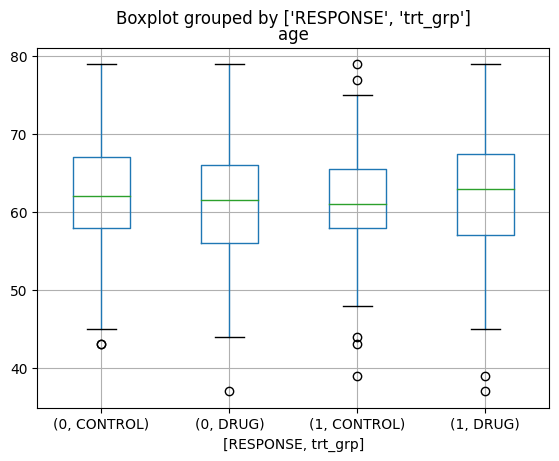

In [28]:
data.boxplot(column="age", by=["RESPONSE", "trt_grp"]) 
plt.show()

Next, we do the same with the weight. We just observe the slight difference between responses that we saw before.

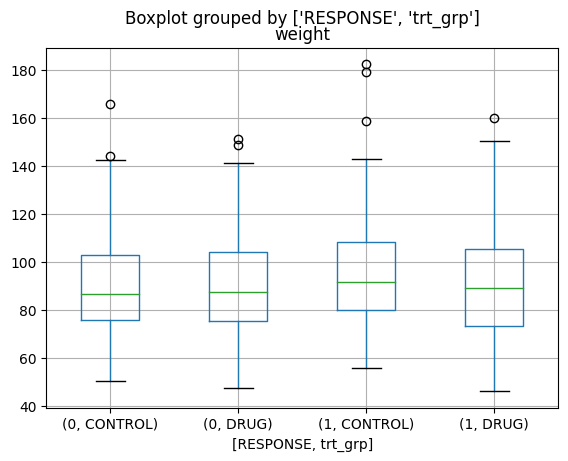

In [29]:
data.boxplot(column="weight", by=["RESPONSE", "trt_grp"])
plt.show()

Now, for the BMI we observe that it is noticeably higher in the positive responders from the control group.

<Axes: title={'center': 'BMI'}, xlabel='[RESPONSE, trt_grp]'>

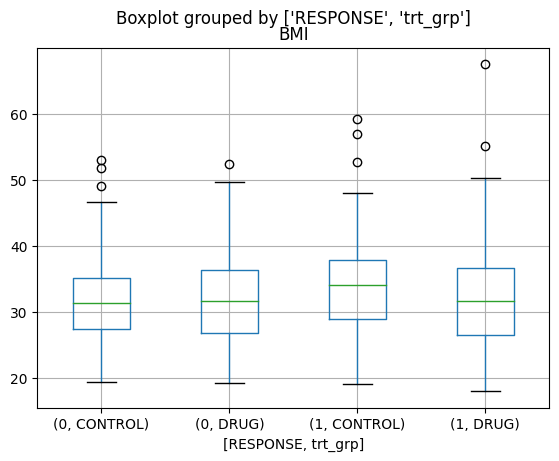

In [30]:
data.boxplot(column="BMI", by=["RESPONSE", "trt_grp"]) 

Finally, the protein levels are clearly higher in non responders, specially in the drug group.

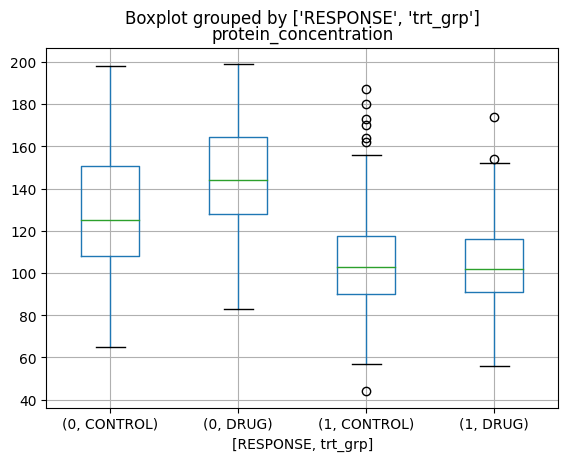

In [31]:
data.boxplot(column="protein_concentration", by=["RESPONSE", "trt_grp"]) 
plt.show()

## 6. Modelling

We have chosen to divide the model into two, one for the control group and another one to improve accuracy and because they are fundamentally different models.

For modelling purposes we drop age and weight, since they are redundant with the BMI. We also transform categorical data into numerical data.

In [32]:
data.drop(columns=["height", "weight"], inplace=True)
data.replace({"Female":0, "Male":1, "CONTROL":0, "DRUG":1},inplace=True)
data.head()

,age,sex,trt_grp,RESPONSE,BMI,protein_concentration
0,46.0,0,1,0,33.487599,148.0
1,47.0,0,1,1,26.476056,85.0
2,48.0,0,0,0,23.338568,183.0
3,59.0,0,1,1,27.973333,89.0
4,59.0,0,0,0,42.873273,137.0


### Drug group
Let us start with the drug group.

In [33]:
drug = data[data["trt_grp"] == 1].drop(columns=["trt_grp"])
X_drug = drug.drop(columns=["RESPONSE"])
y_drug = drug["RESPONSE"]

X_drug_train, X_drug_test, y_drug_train, y_drug_test = train_test_split(X_drug, y_drug, test_size=0.3, random_state=42)

In [36]:
scaler = StandardScaler()
X_drug_train = scaler.fit_transform(X_drug_train)
X_drug_test = scaler.transform(X_drug_test)

In [37]:
model_drug = LogisticRegression(random_state=42)
model_drug.fit(X_drug_train, y_drug_train)

LogisticRegression(random_state=42)

We obtain a very good performance, with an accuracy above 80% in both train and test.

In [41]:
print(f"Train accuracy: {model_drug.score(X_drug_train,y_drug_train)*100:.2f}%")
print(f"Test accuracy: {model_drug.score(X_drug_test,y_drug_test)*100:.2f}%")

Train accuracy: 83.21%
Test accuracy: 83.19%


We now show the feature importance, for which protein concentration is clearly the only really important feature, the BMI being only slightly important and the age and sex barely important at all.

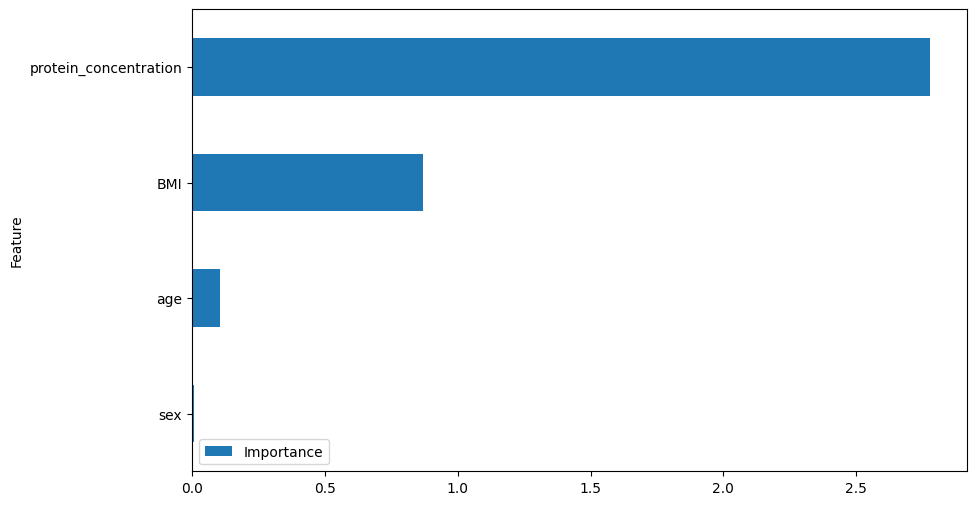

In [43]:
coefficients = model_drug.coef_[0] 
feature_importance = pd.DataFrame({'Feature': X_drug.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))
plt.show()

### Control group
We now do the same for the control group

In [45]:
control = data[data["trt_grp"] == 0].drop(columns=["trt_grp"])
X_control = control.drop(columns=["RESPONSE"])
y_control = control["RESPONSE"]
X_control_train, X_control_test, y_control_train, y_control_test = train_test_split(X_control, y_control, test_size=0.3, random_state=42)
X_train = scaler.fit_transform(X_control_train)
X_test = scaler.transform(X_control_test)
model_control = LogisticRegression(random_state=42)
model_control.fit(X_control_train, y_control_train)

LogisticRegression(random_state=42)

We obtain good accuracy scores again, although not as good as before.

In [46]:
print(f"Train accuracy: {model_control.score(X_control_train,y_control_train)*100:.2f}%")
print(f"Test accuracy: {model_control.score(X_control_test,y_control_test)*100:.2f}%")

Train accuracy: 74.14%
Test accuracy: 78.07%


The feature importance now shows a very different behaviour. Now BMI and age are the most important features and protein concentration is not so relevant. Age stays relatively irrelevant. In any case, looking at the actual values, all the features seem to have little importance in this model compared to the drug group.

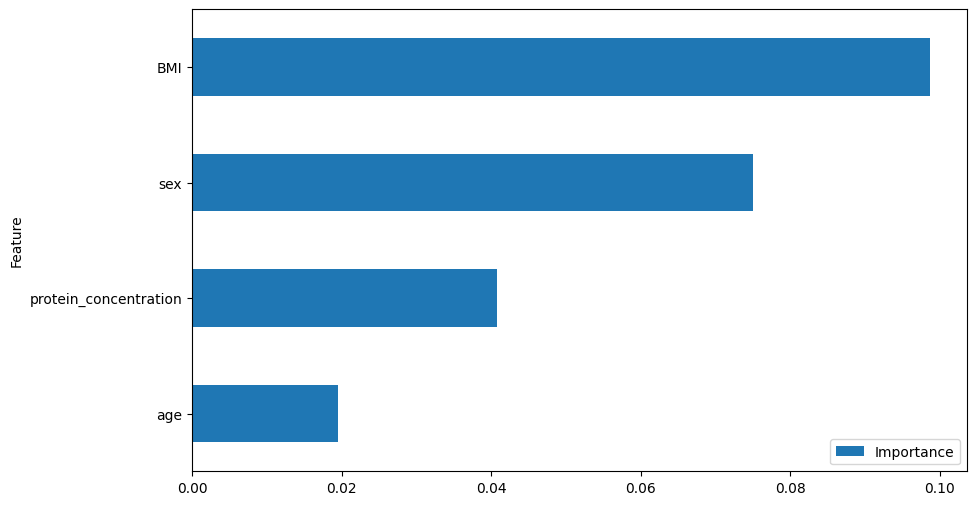

In [47]:
coefficients = model_control.coef_[0] 
feature_importance = pd.DataFrame({'Feature': X_control.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))
plt.show()

## Conclusions

From the comparison of responses and the t-test we can conclude that the drug seems to be effective to increase the response of participants.

From the boxplots we observe that age and weight are not good predictors of the response, while protein concentrain is. This is confirmed by the feature importance of our models. Both of them are good in accuracy, specially the one used for the drug group.